In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets.samples_generator import make_blobs
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn import metrics
%matplotlib inline

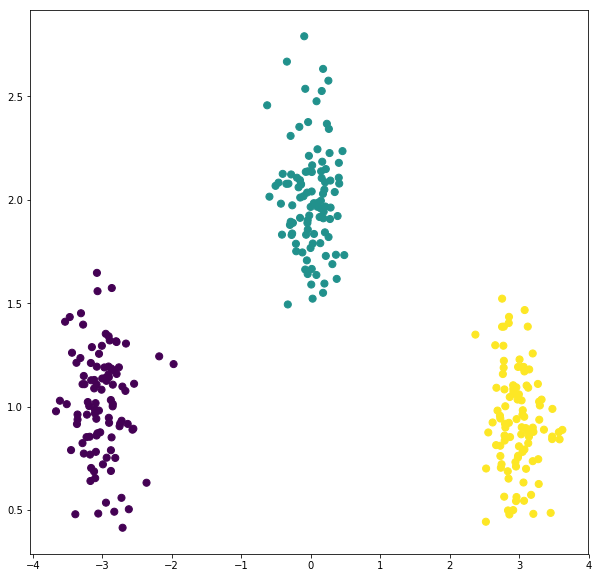

In [246]:
'''
生成训练数据和对应类别.
'''
np.random.seed(2)
X , y = make_blobs(n_samples = 300 , cluster_std = 0.25 , centers = np.array([(-3 , 1) , (0 , 2) , (3 , 1)]))
f , (ax) = plt.subplots(1 , 1 , figsize = (10 , 10))
ax.scatter(X[ : , 0] , X[ : , 1] , c = y , s = 50)
plt.show()

In [250]:
class OneVsAllClassifier(BaseEstimator , ClassifierMixin) :
    '''
    利用OvA原则和基二分类器实现的多分类器.其中基本分类器为sklearn包中的SVM.
    '''
    def __init__(self , estimator , n_classes) :
        '''
        类初始化,生成n_classes个二分类线性SVM.
        Args:
            estimator - 基二分类器 , 类
            n_classes - 类别总数 , 标量
        Returns:
            None
        '''
        self.n_classes = n_classes
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False
    
    def fit(self , X , y = None) :
        '''
        枚举类别,对于每个类别修改标签,当前枚举类别标记为1,其余类别标记为-1.
        利用输入数据和修改的训练输出数据分别对这n_classes个SVM记性拟合.
        Args:
            X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
            y - 类标签 , 一维numpy数组(num_instances)
        Returns:
            None
        '''
        for c in range(self.n_classes) :
            y_ = np.where(y == c , 1 , -1)
            self.estimators[c].fit(X = X , y = y_ , sample_weight = None)
        self.fitted = True
        return self
    
    def decision_function(self , X) :
        '''
        计算每个样本对于所有类别的得分值.
        Args:
            X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
        Returns:
            score - 样本关于类别的得分值 , 二维numpy数组(num_instances , n_classes)
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        score = np.zeros((X.shape[0] , self.n_classes))
        for c in range(self.n_classes) :
            score[ : , c] = self.estimators[c].decision_function(X)
        return score
    
    def predict(self , X) :
        '''
        根据样本关于类别的得分值进行预测.
        Args:
            X - 原始的训练输入数据 , 二维numpy数组(num_instances , num_inFeatures)
        Returns:
            y_ - 预测的样本类别 , 一维numpy数组(num_instances)
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        score = self.decision_function(X)
        y_ = np.argmax(score , axis = 1)
        return y_

In [251]:
def Experiment1() :
    '''
    利用OvA策略和二分类的SVM,训练多分类的SVM,其中n_classes = 3
    '''
    svm_estimator = svm.LinearSVC(loss = 'hinge' , fit_intercept = False , C = 200)
    clf_onevsall = OneVsAllClassifier(svm_estimator , n_classes = 3)
    clf_onevsall.fit(X , y)

    for i in range(3) :
        print ("Coeffs %d"%i)
        print (clf_onevsall.estimators[i].coef_)
    h = 0.02
    x_min , x_max = np.min(X[ : , 0]) - 3 , np.max(X[ : , 0]) + 3
    y_min , y_max = np.min(X[ : , 1]) - 3 , np.max(X[ : , 1]) + 3
    xx , yy = np.meshgrid(np.arange(x_min , x_max , h) , np.arange(y_min , y_max , h))

    mesh_input = np.c_[xx.ravel() , yy.ravel()]

    Z = clf_onevsall.predict(mesh_input)

    Z = Z.reshape(xx.shape)
    plt.figure(figsize = [10 , 10])
    plt.contourf(xx , yy, Z , cmap = plt.cm.coolwarm, alpha = 0.6)
    plt.scatter(X[ : , 0] , X[ : , 1] , c = y , cmap = plt.cm.coolwarm)
    print ('confusion_matrix:\n' , metrics.confusion_matrix(y , clf_onevsall.predict(X)))

Coeffs 0
[[-1.05853502 -0.90294878]]
Coeffs 1
[[ 0.2592022  -0.20190078]]
Coeffs 2
[[ 0.89165805 -0.8246809 ]]
confusion_matrix:
 [[100   0   0]
 [  0 100   0]
 [  0   0 100]]


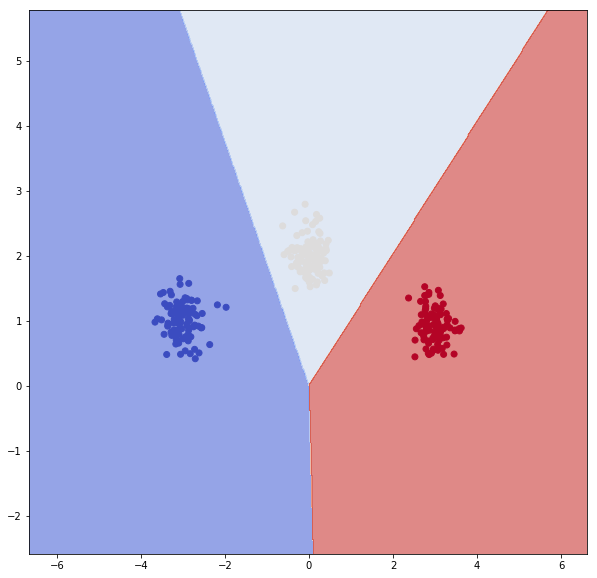

In [252]:
Experiment1()

confusion_matrix:
 [[ 94   6   0]
 [  0 100   0]
 [  0   0 100]]


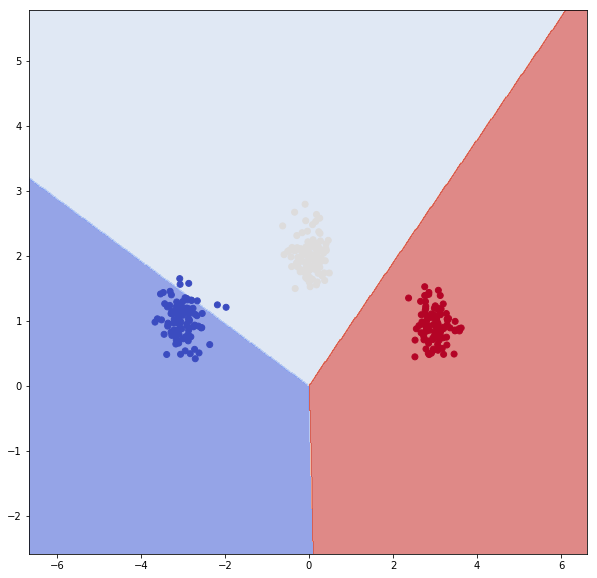

In [229]:
def zero_one(y , a) :
    '''
    0/1函数作为Delta函数.
    Args:
        y - 真实label , 标量
        a - 预测label , 标量
    Returns :
        l - 损失值 , {0 , 1}
    '''
    return int(y != a)

def feature_map(X , y , num_classes) :
    '''
    特征映射Psi:利用原始特征生成关于给定类别y的样本特征(升维).
    Args:
        X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
        y - 给定类别 , 标量
        num_classes - 类别总数 , 标量
    Returns:
        X_ - 经过特征映射后的样本特征 , 二维numpy数组(num_instances , num_outFeatures) .
                                其中num_outFeatures = num_inFeatures * num_classes .
    '''
    num_instances , num_inFeatures = (1 , X.shape[0]) if len(X.shape) == 1 else (X.shape[0] , X.shape[1])
    num_outFeatures = num_inFeatures * num_classes
    if (len(X.shape) == 1) :
        X_ = np.zeros(num_outFeatures)
        X_[y * num_inFeatures : (y + 1) * num_inFeatures] = X
    else :
        X_ = np.zeros((num_instances , num_outFeatures))
        X_[ : , y * num_inFeatures : (y + 1) * num_inFeatures] = X
    return X_

def sgd(X , y , num_outFeatures , subgd , eta = 0.1 , max_iter = 200) :
    '''
    随机次梯度下降法求解多分类SVM.
    Args:
        X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
        y - 训练样本类别 , 一维numpy数组(num_instances)
        num_outFeatures - 特征映射后的特征空间维数
        subgd - 次梯度函数 , 函数
        eta - 学习率 , 标量
        max_iter - 最大迭代次数 , 标量
    Returns:
        w - 模型参数 , 一维numpy数组(num_outFeatures)
    '''
    num_instances = X.shape[0]
    w = np.zeros(num_outFeatures)
    
    for t in range(max_iter) :
        for i in range(num_instances) :
            w = w - eta * subgd(X[i] , y[i] , w)
    return w


In [238]:
class MulticlassSVM(BaseEstimator , ClassifierMixin) :
    '''
    独立实现的多分类SVM类,利用类别敏感的泛化HingeLoss损失函数,对于参数利用随机次梯度下降法求解.
    '''
    def __init__(self , num_outFeatures , lambda_reg = 1.0 , num_classes = 3 , Delta = zero_one , Psi = feature_map) :
        '''
        类初始化.
        Args:
            num_outFeatures - 特征映射后的特征空间维数 , 标量
            lambda_reg - L2正则化系数 , 标量
            num_classes - 类别总数 , 标量
            Delta - 目标margin , 函数
            Psi - 特征映射 , 函数
        '''
        self.num_outFeatures = num_outFeatures
        self.lambda_reg = lambda_reg
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X , y : Psi(X , y , num_classes)
        self.fitted = False
    
    def subgradient(self , x , y , w):
        '''
        次梯度计算函数
        Args:
            x - 样本点的原始特征 , 一维numpy数组(num_inFeatures)
            y - 样本点的类别 , 标量
            w - 模型参数 , 一维numpy数组(num_outFeatures)
        Returns:
            sub_grad - 当前样本点的次梯度 , 一维numpy数组(num_outFeatures)
        '''
        h = [self.Delta(y , k) + np.matmul(self.Psi(x , k) , w) - np.matmul(self.Psi(x , y) , w)  for k in range(self.num_classes)]
        y_ = np.argmax(h)
        sub_grad = self.lambda_reg * w + self.Psi(x , y_) - self.Psi(x , y)
        return sub_grad
    
    def fit(self , X , y , eta = 0.1 , max_iter = 50) :
        '''
        训练拟合函数.
        Args:
            X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
            y - 训练样本类别 , 一维numpy数组(num_instances)
            eta - 学习率 , 标量
            num_iter - 最大迭代次数 , 标量
        Returns:
            None
        '''
        self.coef_ = sgd(X , y , self.num_outFeatures , self.subgradient , eta , max_iter)
        self.fitted = True
        return self
    
    def decision_function(self , X) :
        '''
        计算每个样本对于所有类别的得分值.
        Args:
            X - 原始的训练样本特征 , 二维numpy数组(num_instances , num_inFeatures)
        Returns:
            score - 样本关于类别的得分值 , 二维numpy数组(num_instances , n_classes)
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        
        num_instances , num_inFeatures = (1 , X.shape[0]) if len(X.shape) == 1 else (X.shape[0] , X.shape[1])
        score = np.zeros((num_instances , self.num_classes))
        for k in range(self.num_classes) :
            score[ : , k] = np.matmul(feature_map(X , k , self.num_classes) , self.coef_)
        return score
            
        
    def predict(self , X) :
        '''
        根据样本关于类别的得分值进行预测.
        Args:
            X - 原始的训练输入数据 , 二维numpy数组(num_instances , num_inFeatures)
        Returns:
            y_ - 预测的样本类别 , 一维numpy数组(num_instances)
        '''
        score = self.decision_function(X)
        y_ = np.argmax(score , axis = 1)
        return y_

In [253]:
def Experiment2() :
    '''
    训练多分类的SVM,其中n_classes = 3
    '''
    est = MulticlassSVM(6 , lambda_reg = 1)
    est.fit(X , y)
    print("w:")
    print(est.coef_)
    h = 0.02
    x_min , x_max = np.min(X[ : , 0]) - 3 , np.max(X[ : , 0]) + 3
    y_min , y_max = np.min(X[ : , 1]) - 3 , np.max(X[ : , 1]) + 3
    xx , yy = np.meshgrid(np.arange(x_min , x_max , h) , np.arange(y_min , y_max , h))

    mesh_input = np.c_[xx.ravel() , yy.ravel()]

    Z = est.predict(mesh_input)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = [10 , 10])
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    print ('confusion_matrix:\n' , metrics.confusion_matrix(y , clf_onevsall.predict(X)))

w:
[-0.54281571 -0.182342    0.13176022  0.19652997  0.41105549 -0.01418797]
confusion_matrix:
 [[ 94   6   0]
 [  0 100   0]
 [  0   0 100]]


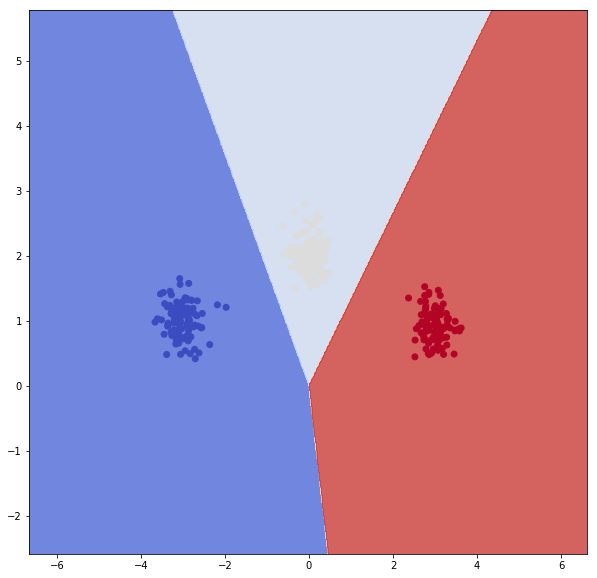

In [254]:
Experiment2()